# Подход 1: градиентный бустинг "в лоб"

## 1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше.

In [1]:
import pandas
features = pandas.read_csv('data\\features.csv', index_col='match_id')

features.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


## Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

```python
# итог матча (отсутствует в тестовых матчах)
"finish": {
    "duration": 2980,             # длительность в секундах
    "radiant_win": false,         # true, если победила команда Radiant
    "tower_status_radiant": 0,    # состояние башен у команд к концу игры
    "tower_status_dire": 1972,    #   (см. описание битовой маски)
    "barracks_status_dire": 63,   # состояние бараков у команд к концу игры
    "barracks_status_radiant": 0  #   (см. описание битовой маски)
}
```

In [2]:
X_train = features

print("Количество столбцов до удаления: ", X_train.shape[1])
# 108

for_removing = ["duration", "radiant_win", "tower_status_radiant", "tower_status_dire", "barracks_status_dire", "barracks_status_radiant"]

for item in for_removing:
    print("  Drop", item)
    X_train = X_train.drop(item, axis=1)
    
print("Количество столбцов после удаления: ", X_train.shape[1])
# 102, OK

Количество столбцов до удаления:  108
  Drop duration
  Drop radiant_win
  Drop tower_status_radiant
  Drop tower_status_dire
  Drop barracks_status_dire
  Drop barracks_status_radiant
Количество столбцов после удаления:  102


## 2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [3]:
row_count = X_train.shape[0]
print("Количество строк в таблице данных:", row_count)
# 97230, если пропусков в столбце нет, должно быть столько заполненных значений

Количество строк в таблице данных: 97230


In [4]:
with_missings = []

for i in X_train.columns:
    count = X_train[i].count()
    if count != row_count:
        print(i, count)
        with_missings.append(i)

print("\nНазвания признаков, имеющих пропуски: ", with_missings)

first_blood_time 77677
first_blood_team 77677
first_blood_player1 77677
first_blood_player2 53243
radiant_bottle_time 81539
radiant_courier_time 96538
radiant_flying_courier_time 69751
radiant_first_ward_time 95394
dire_bottle_time 81087
dire_courier_time 96554
dire_flying_courier_time 71132
dire_first_ward_time 95404

Названия признаков, имеющих пропуски:  ['first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time', 'dire_first_ward_time']


**Названия признаков, имеющих пропуски:** 'first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time', 'dire_first_ward_time'

**Обоснование пропусков.** Выбираем два признака из группы "первая кровь" (first_blood): first_blood_time и first_blood_team. 
Почему их значения могут быть пропущены? Ответ дан в описании признаков: если событие "первая кровь" (first blood) не успело произойти за первые 5 минут, то признаки принимают пропущенное значение.

## 3. Замените пропуски на нули с помощью функции fillna().

In [5]:
X_train['first_blood_time'].head()

match_id
0      7.0
1     54.0
2    224.0
3      NaN
4    -21.0
Name: first_blood_time, dtype: float64

In [6]:
for i in with_missings:
    X_train[i].fillna(0, inplace=True)
    
X_train['first_blood_time'].head()
# Значение с индексом=3 обнулили, ОК

match_id
0      7.0
1     54.0
2    224.0
3      0.0
4    -21.0
Name: first_blood_time, dtype: float64

## 4. Какой столбец содержит целевую переменную? Запишите его название.

Еще раз уточним задачу: "По первым 5 минутам игры предсказать, какая из команд победит: Radiant или Dire?". Следовательно, **целевая переменная** хранится в столбце **radiant_win**. 

In [7]:
y_train = features['radiant_win']
# Проверим, нет ли пропусков
print(y_train.shape[0] == y_train.count())
y_train[:10]

True


match_id
0     1
1     1
2     0
3     0
4     0
5     0
8     0
9     1
11    0
12    0
Name: radiant_win, dtype: int64

## 5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки".

Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
import time
import datetime

def GB(X_train, y_train, n_estimators_range, depth):
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    scores = []
    times = []
    
    for n_est in n_estimators_range:
        print("n_estimators =", n_est)
        start_time = datetime.datetime.now()
    
        clf = GradientBoostingClassifier(n_estimators=n_est, verbose=False, random_state=1, max_depth=depth)
        # clf.fit(X_train, y_train) - не нужно, вопрос о времени сформулирован четко: "Как долго проводилась кросс-валидация...?"
            
        score = cross_val_score(estimator=clf, X=X_train, y=y_train, scoring='roc_auc', cv=kf).mean()    
        scores.append(score)
    
        print("cross_val_score =", score)
    
        time_diff = datetime.datetime.now() - start_time;
        times.append(time_diff.total_seconds())
    
        print("Как долго проводилась кросс-валидация:", time_diff)  
        
    return scores, times

In [9]:
n_estimators_range = [5, 10, 15, 20, 30, 35, 40]
# n_estimators_range = [1, 2]

# Глубина деревьев по умолчанию
scores_3, times_3 = GB(X_train, y_train, n_estimators_range, 3)

n_estimators = 5
cross_val_score = 0.635672292845
Как долго проводилась кросс-валидация: 0:00:15.093863
n_estimators = 10
cross_val_score = 0.664832922805
Как долго проводилась кросс-валидация: 0:00:26.345507
n_estimators = 15
cross_val_score = 0.675966686078
Как долго проводилась кросс-валидация: 0:00:36.869109
n_estimators = 20
cross_val_score = 0.68211403695
Как долго проводилась кросс-валидация: 0:00:49.564835
n_estimators = 30
cross_val_score = 0.689694754206
Как долго проводилась кросс-валидация: 0:01:09.983003
n_estimators = 35
cross_val_score = 0.692151076427
Как долго проводилась кросс-валидация: 0:01:20.858625
n_estimators = 40
cross_val_score = 0.693934191602
Как долго проводилась кросс-валидация: 0:01:32.502291


In [10]:
# Пробуем уменьшить глубину деревьев (max_depth)
kf = KFold(n_splits=5, random_state=1, shuffle=True)
scores_2, times_2 = GB(X_train, y_train, n_estimators_range, 2)

n_estimators = 5
cross_val_score = 0.621054997297
Как долго проводилась кросс-валидация: 0:00:09.249529
n_estimators = 10
cross_val_score = 0.650230450279
Как долго проводилась кросс-валидация: 0:00:15.186869
n_estimators = 15
cross_val_score = 0.665248312702
Как долго проводилась кросс-валидация: 0:00:21.011201
n_estimators = 20
cross_val_score = 0.673459569532
Как долго проводилась кросс-валидация: 0:00:26.937541
n_estimators = 30
cross_val_score = 0.681695188308
Как долго проводилась кросс-валидация: 0:00:38.861223
n_estimators = 35
cross_val_score = 0.684991008324
Как долго проводилась кросс-валидация: 0:00:45.230587
n_estimators = 40
cross_val_score = 0.687273233717
Как долго проводилась кросс-валидация: 0:00:51.626953


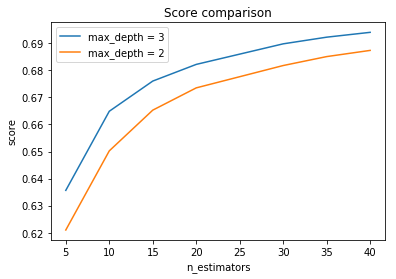

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(n_estimators_range, scores_3, label='max_depth = 3')
plt.plot(n_estimators_range, scores_2, label='max_depth = 2')
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Score comparison')
plt.legend()
# plt.savefig('estimators_score.png')
plt.show()

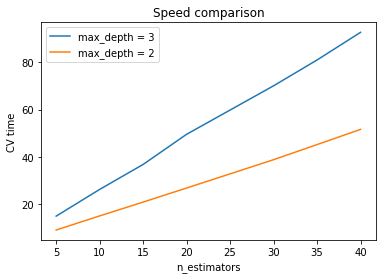

In [12]:
plt.plot(n_estimators_range, times_3, label='max_depth = 3')
plt.plot(n_estimators_range, times_2, label='max_depth = 2')
plt.xlabel('n_estimators')
plt.ylabel('CV time')
plt.title('Speed comparison')
plt.legend()
plt.show()

## Ответы на вопросы

#### Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? 
0:01:10.495032

#### Какое качество при этом получилось? 
0.689694754206 (метрика AUC_ROC)

#### Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении? 
Качество продолжит расти, проверено при n_estimators = 35 и 40.

#### Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев? 
Внимательно читаем советы и рекомендации из задания, проверяем, соглашаемся: 

- Использовать для обучения и кросс-валидации не всю выборку, а некоторое ее подмножество.
- Уменьшить глубину деревьев в градиентом бустинге (max_depth).

# Подход 2: логистическая регрессия

## 1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга.

Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [13]:
# Важно: не забывайте, что линейные алгоритмы чувствительны к масштабу признаков!
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

kf = KFold(n_splits=5, random_state=1, shuffle=True)

In [14]:
from sklearn.linear_model import LogisticRegression

def LR(X, y, C_range):
    scores = []
    times = []
    
    for C_param in C_range:
        print("C =", C_param)
        start_time = datetime.datetime.now()
    
        clf = LogisticRegression(C=C_param, random_state=1)
                            
        score = cross_val_score(estimator=clf, X=X, y=y, scoring='roc_auc', cv=kf).mean()    
        scores.append(score)
    
        print("cross_val_score =", score)
    
        time_diff = datetime.datetime.now() - start_time;
        times.append(time_diff.total_seconds())
    
        print("Как долго проводилась кросс-валидация:", time_diff)  
        
    max_score = max(scores)
    max_score_index = scores.index(max_score)
    print("Max_score =", max_score)
    print("C =", C_range[max_score_index])
    
    plt.plot(C_pow_range, scores)
    plt.xlabel('log(C)')
    plt.ylabel('Score')
    plt.show()

C = 1e-05
cross_val_score = 0.69517710568
Как долго проводилась кросс-валидация: 0:00:03.765215
C = 0.0001
cross_val_score = 0.711286514834
Как долго проводилась кросс-валидация: 0:00:05.879336
C = 0.001
cross_val_score = 0.716209636009
Как долго проводилась кросс-валидация: 0:00:11.043632
C = 0.01
cross_val_score = 0.716375795913
Как долго проводилась кросс-валидация: 0:00:14.671839
C = 0.1
cross_val_score = 0.71635092993
Как долго проводилась кросс-валидация: 0:00:15.635894
C = 1
cross_val_score = 0.716347270307
Как долго проводилась кросс-валидация: 0:00:15.741901
Max_score = 0.716375795913
C = 0.01


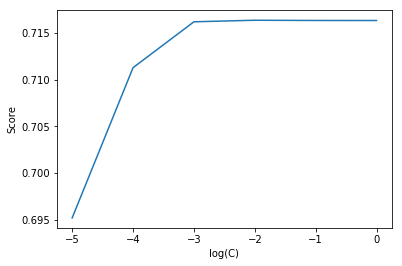

In [15]:
C_pow_range = range(-5,1);
C_range = [10 ** i for i in C_pow_range]
LR(X_train_scaled, y_train, C_range)

## 2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей.
Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [16]:
print("Количество столбцов до удаления: ", X_train.shape[1])
# 102

for_removing = ["lobby_type", "r1_hero", "r2_hero", "r3_hero", "r4_hero", "r5_hero", "d1_hero", "d2_hero", "d3_hero", "d4_hero", "d5_hero"]

for item in for_removing:
    print("  Drop", item)
    X_train = X_train.drop(item, axis=1)
    
print("Количество столбцов после удаления: ", X_train.shape[1])
# 91, OK

Количество столбцов до удаления:  102
  Drop lobby_type
  Drop r1_hero
  Drop r2_hero
  Drop r3_hero
  Drop r4_hero
  Drop r5_hero
  Drop d1_hero
  Drop d2_hero
  Drop d3_hero
  Drop d4_hero
  Drop d5_hero
Количество столбцов после удаления:  91


C = 1e-05
cross_val_score = 0.695111069435
Как долго проводилась кросс-валидация: 0:00:03.478198
C = 0.0001
cross_val_score = 0.71126295007
Как долго проводилась кросс-валидация: 0:00:05.532317
C = 0.001
cross_val_score = 0.716233310372
Как долго проводилась кросс-валидация: 0:00:09.813561
C = 0.01
cross_val_score = 0.716408870274
Как долго проводилась кросс-валидация: 0:00:13.349764
C = 0.1
cross_val_score = 0.716383801538
Как долго проводилась кросс-валидация: 0:00:14.308818
C = 1
cross_val_score = 0.71638033903
Как долго проводилась кросс-валидация: 0:00:14.383823
Max_score = 0.716408870274
C = 0.01


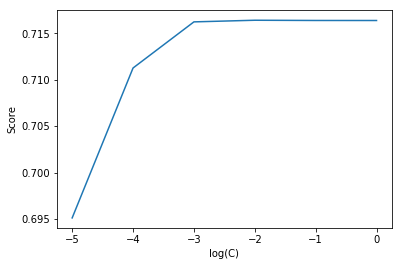

In [17]:
X_train_scaled = scaler.fit_transform(X_train)
LR(X_train_scaled, y_train, C_range)
# Качество незначительно улучшилось

## 3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. 
Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [18]:
for_removing.remove('lobby_type')

In [19]:
import numpy as np
heroes = np.array([])

for item in for_removing:
    heroes = np.append(heroes, features[item].unique())

unique = np.unique(heroes)
N = np.count_nonzero(unique)
print(N)
# 108 геров

108


## 4. Воспользуемся подходом "мешок слов" для кодирования информации о героях.
Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [20]:
N = int(max(unique)) + 1

In [21]:
# N — количество различных героев в выборке
# номера героев 
X_pick = np.zeros((X_train.shape[0], N))

for i, match_id in enumerate(features.index):
    if i % 5000 == 0:
        print(i)
    for p in range(1,6):
        r_index = features['r%d_hero' % p][match_id]
        d_index = features['d%d_hero' % p][match_id]
        X_pick[i, r_index] = 1 
        X_pick[i, d_index] = -1

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000


In [22]:
print(np.shape(X_train_scaled))
print(np.shape(X_pick))

(97230, 91)
(97230, 113)


In [23]:
X_train_scaled = np.concatenate((X_train_scaled, X_pick), axis=1)
print(np.shape(X_train_scaled))
# Проверяем корректность добавления признаков

(97230, 204)


## 5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

C = 1e-05
cross_val_score = 0.699229689345
Как долго проводилась кросс-валидация: 0:00:03.744214
C = 0.0001
cross_val_score = 0.725009127603
Как долго проводилась кросс-валидация: 0:00:06.201355
C = 0.001
cross_val_score = 0.746212139498
Как долго проводилась кросс-валидация: 0:00:12.446712
C = 0.01
cross_val_score = 0.751651585454
Как долго проводилась кросс-валидация: 0:00:20.591178
C = 0.1
cross_val_score = 0.751873040025
Как долго проводилась кросс-валидация: 0:00:29.167668
C = 1
cross_val_score = 0.751857202856
Как долго проводилась кросс-валидация: 0:00:31.318791
Max_score = 0.751873040025
C = 0.1


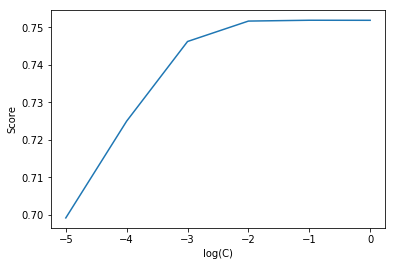

In [ ]:
LR(X_train_scaled, y_train, C_range)

## 6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). 
Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [ ]:
# Повторяем предобработку для тестовой выборки
features_test = pandas.read_csv('data\\features_test.csv', index_col='match_id')
X_test = features_test
row_count = X_test.shape[0]

with_missings = []

for i in X_test.columns:
    count = X_test[i].count()
    if count != row_count:
        with_missings.append(i)
        
for i in with_missings:
    X_test[i].fillna(0, inplace=True)     
    
for_removing = ["lobby_type", "r1_hero", "r2_hero", "r3_hero", "r4_hero", "r5_hero", "d1_hero", "d2_hero", "d3_hero", "d4_hero", "d5_hero"]

for item in for_removing:
    print("  Drop", item)
    X_test = X_test.drop(item, axis=1)
    
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

X_pick = np.zeros((X_test.shape[0], N))

for i, match_id in enumerate(features_test.index):
    if i % 5000 == 0:
        print(i)
    for p in range(1,6):
        r_index = features_test['r%d_hero' % p][match_id]
        d_index = features_test['d%d_hero' % p][match_id]
        X_pick[i, r_index] = 1 
        X_pick[i, d_index] = -1
        
X_test_scaled = np.concatenate((X_test_scaled, X_pick), axis=1)

  Drop lobby_type
  Drop r1_hero
  Drop r2_hero
  Drop r3_hero
  Drop r4_hero
  Drop r5_hero
  Drop d1_hero
  Drop d2_hero
  Drop d3_hero
  Drop d4_hero
  Drop d5_hero
0


In [ ]:
clf = LogisticRegression(C=0.1, random_state=1)
clf.fit(X_train_scaled, y_train)
pred = clf.predict_proba(X_test_scaled)[:, 1]

In [ ]:
print(min(pred))
print(max(pred))
# Значения адекватные

## Ответы на вопросы
#### Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

Максимальное значение качества (метрика AUC_ROC) 0.716375795913 получено при значении C = 0.01. 

При сопоставимом времени обучения качество у LR получилось выше, чем у GB (0.716375795913 > 0.689694754206). Хотя, как было отмечено в первом блоке вопросов, существуют возможности для повышения качества GB. Линейные методы работают быстрее композиций деревьев, но требуют дополнительной предобработки исходных данных.

#### Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?

Новое значение метрики качества (AUC_ROC) 0.716408870274 получено при значении C = 0.01. Это чуть "лучше", чем при включении категориальных признаков в признаковое пространство. Можно согласиться с тем, что наличие таких признаков при прочих равных условиях усложняет (ухудшает) качество LR. 

С другой стороны, исключая часть признаков, мы уменьшаем количество информации, доступной для модели (возможно, полезной для обучения).

"На данный момент не существует общепринятого стандартного «де-факто» набора алгоритмов для решения задач машинного обучения с категориальными признаками." Помимо используемого числового кодирования существует множество различных эвристик обработки таких признаков (частотное кодирование и др.). Использование таких эвристик также может повысить качество работы LR.

#### Сколько различных идентификаторов героев существует в данной игре?

108

#### Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?

Значение метрики качества (AUC_ROC) при использовании "мешка слов" = 0.751870002273 (получено при значении C = 0.1). Оно улучшилось по сравнению с предыдущим вариантом (0.751870002273 > 0.716408870274). Значит, применение такой эвристики для учета информации об участвующих героях лучше, чем использование простого кодирования (1 вариант) или только удаление соответствующих категориальных признаков (2 вариант).

#### Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?
+ Минимальное значение = 0.00858056961074
+ Максимальное значение = 0.996458680349